## Tutorial 8: Monte Carlo error analysis

Here we will demonstrate how one could set up a Monte Carlo analysis of uncertainties using **meltPT**. In doing so we will recreate the analysis shown in Figure 2 of M<sup>c</sup>Nab & Ball (in rev., Volcanica).

Start by importing the libraries we will need:

In [1]:
from meltPT import *
import pyMelt as m
import matplotlib.pyplot as plt
import random

# A useful class

We will start by defining a class for storing information about parameters and their uncertainties. This will come in handy later.

In [2]:
class Parameter:
    def __init__(self, val, plus, minus):
        self.val = val
        self.plus = plus
        self.minus = minus
    
    def draw_normal(self):
        return random.gauss(self.val, (self.plus+self.minus)/2.)
        
    def range(self, n=10):
        return np.linspace(self.val-(3.*self.minus), self.val+(3.*self.plus), n)
        
    def gaussian(self):
        sd = (self.plus+self.minus)/2.
        return (
            (1./(sd*np.sqrt(2.*np.pi))) * 
            np.exp(-0.5*(((self.range(n=100)-self.val)/sd)**2.))
            )

# Parameters values

Next we need to define the values and uncertainties of the parameters of interest. Here, we will explore uncertainties in source Fo#, melt Fe<sup>3+</sup>/$\Sigma$Fe, and melt water content.

In [3]:
src_FeIII_totFe = Parameter(0.17, 0.005, 0.005)
src_Fo = Parameter(0.9, 0.005, 0.005)
H2O = Parameter(1.376785, 0.1, 0.1)

# Basic run

First we will do a simple run with the mean values of each parameter.

In [4]:
# Set up the pyMeltmantle object
lz = m.lithologies.katz.lherzolite()
mantle = m.mantle([lz], [1], ['Lz'])

# Do the basic analysis
s = Suite(
    "../Data/PF16_UT09DV04.csv", 
    src_FeIII_totFe=src_FeIII_totFe.val, 
    src_Fo=src_Fo.val)
b = BacktrackOlivineFractionation(Kd=0.3)
s.backtrack_compositions(backtracker=b)
s.compute_pressure_temperature(method="PF16")
s.find_individual_potential_temperatures(mantle)

/home/mcnab/Melting/meltPT/meltPT/parse.py:79: UserWarning: Input csv does not contain a Fe2O3 column: we will try to fill it for you, or set it to zero.
  warnings.warn(message)
/home/mcnab/Melting/meltPT/meltPT/parse.py:79: UserWarning: Input csv does not contain a Cr2O3 column: we will try to fill it for you, or set it to zero.
  warnings.warn(message)
/home/mcnab/Melting/meltPT/meltPT/parse.py:79: UserWarning: Input csv does not contain a NiO column: we will try to fill it for you, or set it to zero.
  warnings.warn(message)
/home/mcnab/Melting/meltPT/meltPT/parse.py:79: UserWarning: Input csv does not contain a CoO column: we will try to fill it for you, or set it to zero.
  warnings.warn(message)
/home/mcnab/Melting/meltPT/meltPT/parse.py:79: UserWarning: Input csv does not contain a CO2 column: we will try to fill it for you, or set it to zero.
  warnings.warn(message)
/home/mcnab/Melting/meltPT/meltPT/parse.py:79: UserWarning: Input csv does not contain a FeO_tot column: we wil

# Monte Carlo run

Now we will redo this analysis 1000 times, selecting parameter values at random from the distributions defined above. Since the thermobarometric scheme itself also introduces some uncertainty, we also draw pressures and temperatures from distributions defined by the thermobarometric results and its uncertainty.

In [7]:
# Create an empty list to store the resulting Suite objects
suites = []

# Start the iteration
for i in range(100):
    print("Working on iteration", i, end='\r')
    
    # Create a suite object with random values
    si = Suite(
        "../Data/PF16_UT09DV04.csv", 
        src_FeIII_totFe=src_FeIII_totFe.draw_normal(), 
        src_Fo=src_Fo.draw_normal())
    
    # Overwrite water content with random values
    si.data.at[0, 'H2O'] = H2O.draw_normal()
    
    # Backtrack
    si.backtrack_compositions(backtracker=b)
    
    # Compute pressures and temperatures
    si.compute_pressure_temperature(method="PF16")
    
    # Overwrite pressures and temperatures with random values
    si.PT.at[0,'P'] = Parameter(si.PT.at[0,'P'], si.PT.at[0,'P_err'], si.PT.at[0,'P_err']).draw_normal()
    si.PT.at[0,'T'] = Parameter(si.PT.at[0,'T'], si.PT.at[0,'T_err'], si.PT.at[0,'T_err']).draw_normal()
    
    # Perform Tp fit
    si.find_individual_potential_temperatures(mantle)
    
    # Save result
    suites.append(si)

# Results

Now let's have a look at our results, first of all checking the distributions of input parameters we ended up with.

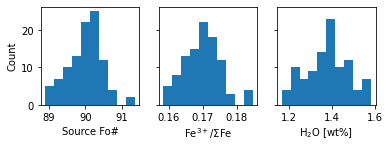

In [37]:
# Set up subplots
fig, axs = plt.subplots(1, 3, sharey=True)

# Plot the histograms
axs[0].hist([si.data.iloc[0]['src_Fo']*100 for si in suites])
axs[1].hist([si.data.iloc[0]['src_FeIII_totFe'] for si in suites])
axs[2].hist([si.data.iloc[0]['H2O'] for si in suites])

# Axes labels
axs[0].set_ylabel("Count")
axs[0].set_xlabel("Source Fo#")
axs[1].set_xlabel(r"Fe$^{3+}$/$\Sigma$Fe")
axs[2].set_xlabel(r"H$_{2}$O [wt%]")

# Make them square
for ax in axs:
    ax.set_box_aspect(1)

# Show
plt.show()

Now let's look at the results in pressure-temperature space.

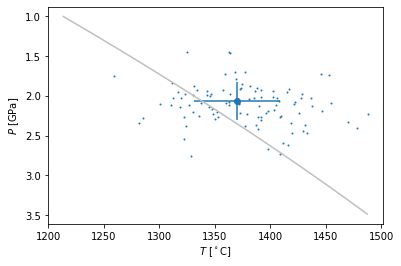

In [41]:
P = np.arange(1., 3.5, 0.01)
plt.plot(lz.TSolidus(P), P, c="0.75")
plt.scatter(
    [si.PT['T'].iloc[0] for si in suites], 
    [si.PT['P'].iloc[0] for si in suites], 
    s=1)
plt.errorbar(s.PT['T'], s.PT['P'], xerr=s.PT['T_err'], yerr=s.PT['P_err'], marker="o")
plt.gca().invert_yaxis()
plt.xlabel(r"$T$ [$^\circ$C]")
plt.ylabel(r"$P$ [GPa]")

plt.show()

... and the distributions of pressure, temperature and potential temperature.

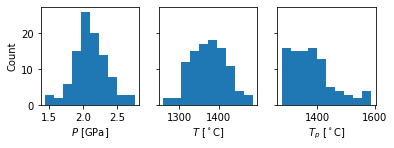

In [43]:
# Set up subplots
fig, axs = plt.subplots(1, 3, sharey=True)

# Plot the histograms
axs[0].hist([si.PT.iloc[0]['P'] for si in suites if not np.isnan(si.PT.iloc[0]['P'])])
axs[1].hist([si.PT.iloc[0]['T'] for si in suites if not np.isnan(si.PT.iloc[0]['T'])])
axs[2].hist([si.individual_potential_temperatures.iloc[0]['Tp'] for si in suites 
                 if not np.isnan(si.individual_potential_temperatures.iloc[0]['Tp'])])

# Axes labels
axs[0].set_ylabel("Count")
axs[0].set_xlabel("$P$ [GPa]")
axs[1].set_xlabel(r"$T$ [$^\circ$C]")
axs[2].set_xlabel(r"$T_p$ [$^\circ$C]")

# Make them square
for ax in axs:
    ax.set_box_aspect(1)

# Show
plt.show()